In [1]:
%config InlineBackend.figure_format = 'retina'
import matplotlib.pyplot as plt
import numpy as np

import pandas as pd
import os
import uproot
from scipy import interpolate
from scipy.optimize import curve_fit, fsolve

plt.style.use('physics.mplstyle')

In [3]:
f = uproot.open("../higgsCombineSUEP-m1000-darkPho.AsymptoticLimits.mH125.root")
limit = f['limit']['limit'].array(library="np")
limit

array([0.04204559, 0.05685711, 0.08154297, 0.11872392, 0.16403821,
       0.04468787])

In [4]:
def get_limits(fn):
    f = uproot.open(fn)
    limit = f["limit"]['limit'].array(library="np")
    quant = f["limit"]['quantileExpected'].array(library="np")
    
    if limit.shape[0] == 1:
        return -1
    else:
        return np.stack([quant,limit])

def get_SUEP_file(Mass=125, decay="darkPho", path="./"):
    fname = os.path.join(
        "../higgsCombineSUEP-m{}-{}.AsymptoticLimits.mH125.root".format(Mass, decay)
    )
    #print (fname)
    if os.path.isfile(fname):
        return fname
    else:
        pass

In [5]:
masses = [125, 400, 750, 1000]
decay = "generic"
print(decay)
for m in masses:
    limit = get_limits(get_SUEP_file(Mass=m, decay=decay))
    print("SUEP m-"+ str(m), "\t: ", 
             np.round(limit[1,2],5), "\t+/- [",
             np.round(limit[1,3],5), ",",
             np.round(limit[1,1],5), "]"
        )

generic
SUEP m-125 	:  426.0 	+/- [ 616.1955 , 297.03516 ]
SUEP m-400 	:  0.58594 	+/- [ 0.85032 , 0.40855 ]
SUEP m-750 	:  0.17676 	+/- [ 0.25651 , 0.12306 ]
SUEP m-1000 	:  0.13867 	+/- [ 0.20124 , 0.09669 ]


In [11]:
def plot_dim_interpolate(decay="darkPho", unblind=True, quadratic=False):
    limits = []
    limitx = []
    for Mass in [125,400,750,1000]:
    #for Mass in [400,1000]:
        try:
            limit = get_limits(get_SUEP_file(Mass=Mass, decay=decay))

            if not isinstance(limit, int) and limit.shape == (2,6):
                limits.append(limit)
                limitx.append(Mass)
        except:
            print(" failed : ", Mass, " : ", decay)
            pass
    limits = np.array(limits)
    limitx = np.array(limitx)
    
    _exp = np.array([l[1][2] for l in limits]) 
    _s1p = np.array([l[1][1] for l in limits]) 
    _s1m = np.array([l[1][3] for l in limits]) 
    _s2p = np.array([l[1][0] for l in limits]) 
    _s2m = np.array([l[1][4] for l in limits])
    _obs = np.array([l[1][5] for l in limits])
    
    print(_exp)
    print(_s2p)
    print(_s2m)
    
    if quadratic:
        exp_limit = interpolate.interp1d(limitx, _exp, bounds_error=False, fill_value="extrapolate", kind="quadratic")
        s1p_limit = interpolate.interp1d(limitx, _s1p, bounds_error=False, fill_value="extrapolate", kind="quadratic")
        s1m_limit = interpolate.interp1d(limitx, _s1m, bounds_error=False, fill_value="extrapolate", kind="quadratic")
        s2p_limit = interpolate.interp1d(limitx, _s2p, bounds_error=False, fill_value="extrapolate", kind="quadratic")
        s2m_limit = interpolate.interp1d(limitx, _s2m, bounds_error=False, fill_value="extrapolate", kind="quadratic")
        obs_limit = interpolate.interp1d(limitx, _obs, bounds_error=False, fill_value="extrapolate", kind="quadratic")
    else:
        exp_limit = interpolate.interp1d(limitx, _exp, bounds_error=False, fill_value="extrapolate", kind="linear")
        s1p_limit = interpolate.interp1d(limitx, _s1p, bounds_error=False, fill_value="extrapolate", kind="linear")
        s1m_limit = interpolate.interp1d(limitx, _s1m, bounds_error=False, fill_value="extrapolate", kind="linear")
        s2p_limit = interpolate.interp1d(limitx, _s2p, bounds_error=False, fill_value="extrapolate", kind="linear")
        s2m_limit = interpolate.interp1d(limitx, _s2m, bounds_error=False, fill_value="extrapolate", kind="linear")
        obs_limit = interpolate.interp1d(limitx, _obs, bounds_error=False, fill_value="extrapolate", kind="linear")
    plt.figure(figsize=(6,6))
    ax = plt.gca()
    
    plt.plot(limitx, _exp,'.', ms=12, color='black')
    xvar = np.linspace(80,1100,1001)
    plt.plot(xvar, exp_limit(xvar), ls="--", ms=12, color='black', label="Median expected")
    
    plt.fill_between(xvar, s2m_limit(xvar), s2p_limit(xvar), color="#FFCC01", lw=0, label="Expected $\pm 2\sigma$")
    plt.fill_between(xvar, s1m_limit(xvar), s1p_limit(xvar), color="#00CC00", lw=0, label="Expected $\pm 1\sigma$")

    #Observed limit
    #plt.plot(limitx, _obs,'.', ms=12, color='black')
    #plt.plot(xvar, obs_limit(xvar), ls="-", ms=12, color='black', label="Median Observed")
    
    #Theoretical cross section
    #plt.plot(thxsec[thxsec.d==dim].Md, 
    #         thxsec[thxsec.d==dim].xsec, #*.101,#* 0.101* 2/3, 
    #         "--", ms=12, color='blue', label="$\sigma_{theory}$ (pb), n = %i" % (dim))
    plt.ylim([0.0, 200])
    plt.xlim([80, 1100 ])
    
    plt.ylabel(r"$\sigma(SUEP)$ (fb)")
    plt.xlabel(r"$M_{SUEP}$ (TeV)")
    plt.legend(loc="upper left", fontsize=14)
    cms = plt.text(
        0., 1., u"CMS $\it{preliminary}$",
        fontsize=16, fontweight='bold',
        horizontalalignment='left', 
        verticalalignment='bottom', 
        transform=ax.transAxes
    )
    lumi = plt.text(
        1., 1., r"%.1f fb$^{-1}$ (13 TeV)" % 60.0,
        fontsize=14, horizontalalignment='right', 
        verticalalignment='bottom', 
        transform=ax.transAxes
    )
    plt.grid(b=True, which='major', color='grey', linestyle='--', alpha=0.3)
    #plt.savefig("plots/SUEP_limits_d_{}.pdf".format(decay))
    #plt.savefig("plots/SUEP_limits_d_{}.png".format(decay))
    plt.yscale("log")
    plt.ylim(1e-2,1e3)
    plt.show()

decay :  darkPho
[14.3125      0.40820312  0.12207031  0.08154297]
[7.32397461 0.21047974 0.0629425  0.04204559]
[28.63255119  0.81977981  0.24514946  0.16403821]


/tmp/ipykernel_145213/196318549.py:80: MatplotlibDeprecationWarning: The 'b' parameter of grid() has been renamed 'visible' since Matplotlib 3.5; support for the old name will be dropped two minor releases later.
  plt.grid(b=True, which='major', color='grey', linestyle='--', alpha=0.3)


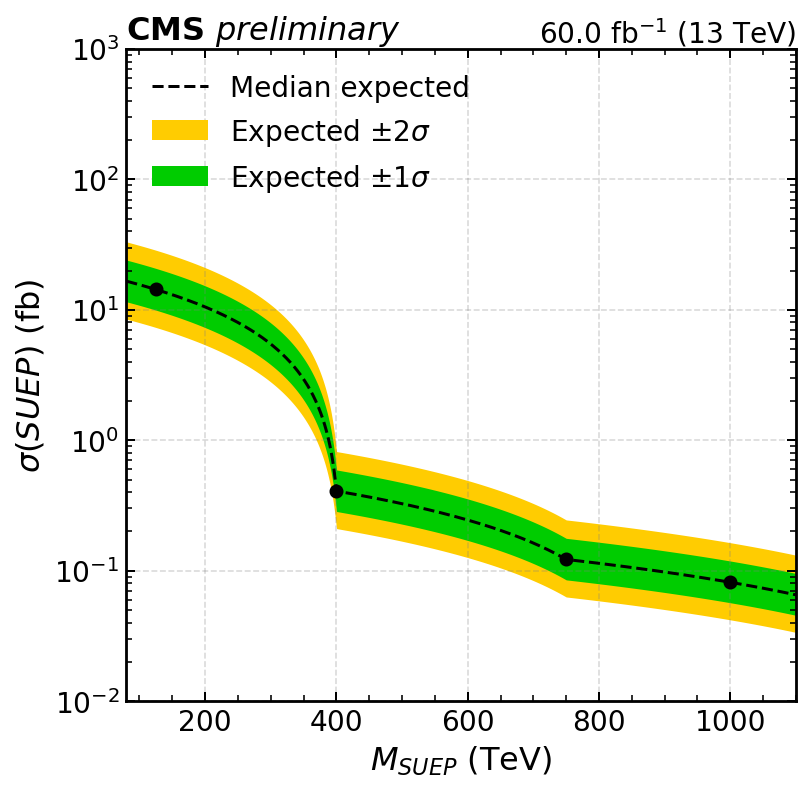

decay :  darkPhoHad
[13.3125      0.41992188  0.11523438  0.06835938]
[6.86425781 0.21652222 0.05941772 0.0352478 ]
[26.63202477  0.84331417  0.2314211   0.1372837 ]


/tmp/ipykernel_145213/196318549.py:80: MatplotlibDeprecationWarning: The 'b' parameter of grid() has been renamed 'visible' since Matplotlib 3.5; support for the old name will be dropped two minor releases later.
  plt.grid(b=True, which='major', color='grey', linestyle='--', alpha=0.3)


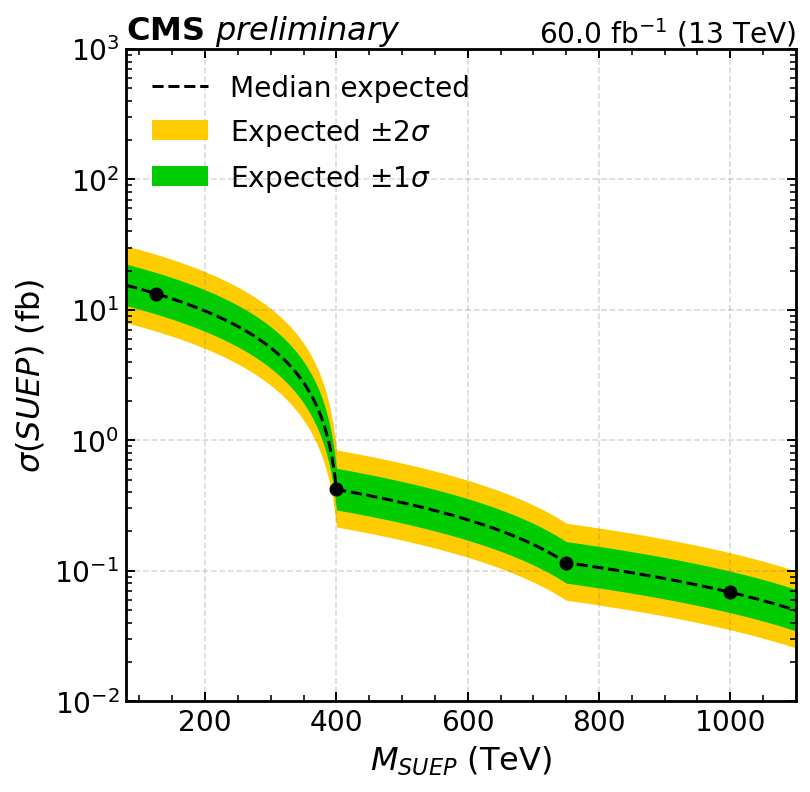

decay :  generic
[4.26000000e+02 5.85937500e-01 1.76757812e-01 1.38671875e-01]
[2.19656250e+02 3.02124023e-01 8.97598267e-02 7.15026855e-02]
[8.44155029e+02 1.17218411e+00 3.53608906e-01 2.79562652e-01]


/tmp/ipykernel_145213/196318549.py:80: MatplotlibDeprecationWarning: The 'b' parameter of grid() has been renamed 'visible' since Matplotlib 3.5; support for the old name will be dropped two minor releases later.
  plt.grid(b=True, which='major', color='grey', linestyle='--', alpha=0.3)


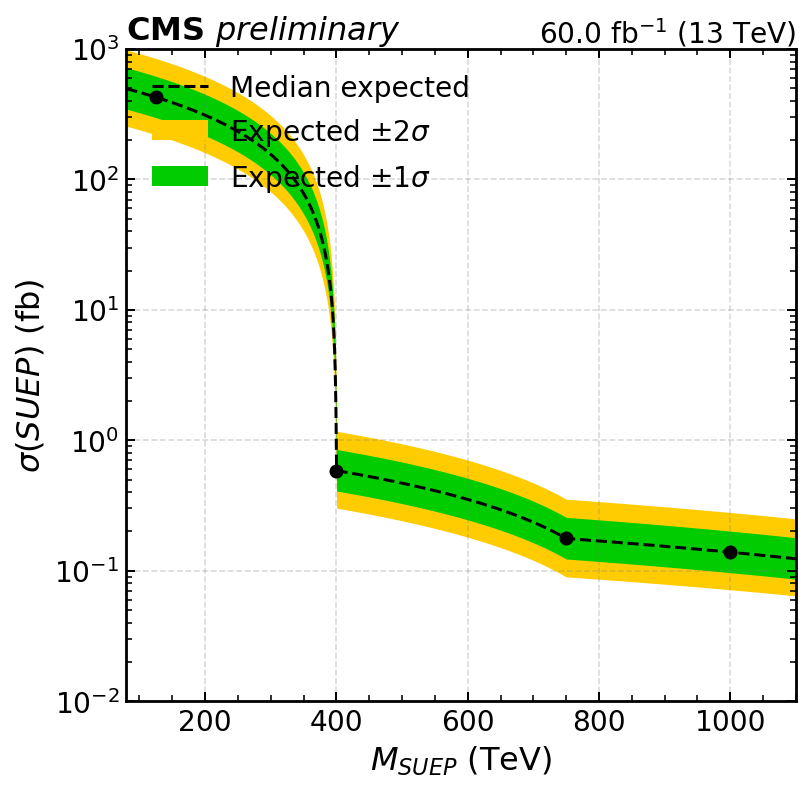

In [12]:
for decay in ["darkPho","darkPhoHad","generic"]:
    print("decay : ", decay)
    plot_dim_interpolate(decay=decay, unblind=False, quadratic=False)